# Model Interpretability & Feature Analysis

This notebook helps you understand **what your model learned** and **why it makes certain predictions**.

## What You'll Learn:
1. **Feature Importance** - Which words are most predictive
2. **Word Clouds** - Visual representation of important words
3. **SHAP Analysis** - Individual prediction explanations
4. **Misclassification Analysis** - Understanding errors
5. **Model Behavior** - How the model makes decisions

In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [10]:
# Load data and train model
print("=== LOADING DATA ===")
df = pd.read_csv("../data/cleaned_data.csv")
print(f"Dataset shape: {df.shape}")

# Prepare data
X = df['content']
y = df['target']
class_names = ["Stress", "Depression", "Bipolar", "Personality", "Anxiety"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train model
model = LinearSVC(random_state=42, max_iter=2000)
model.fit(X_train_tfidf, y_train)

# Get predictions
y_pred = model.predict(X_test_tfidf)
accuracy = (y_pred == y_test).mean()

print(f"\n✅ Model trained with {accuracy:.4f} accuracy")
print("="*50)

=== LOADING DATA ===
Dataset shape: (5957, 2)

✅ Model trained with 0.8112 accuracy

✅ Model trained with 0.8112 accuracy


=== FEATURE IMPORTANCE ANALYSIS ===


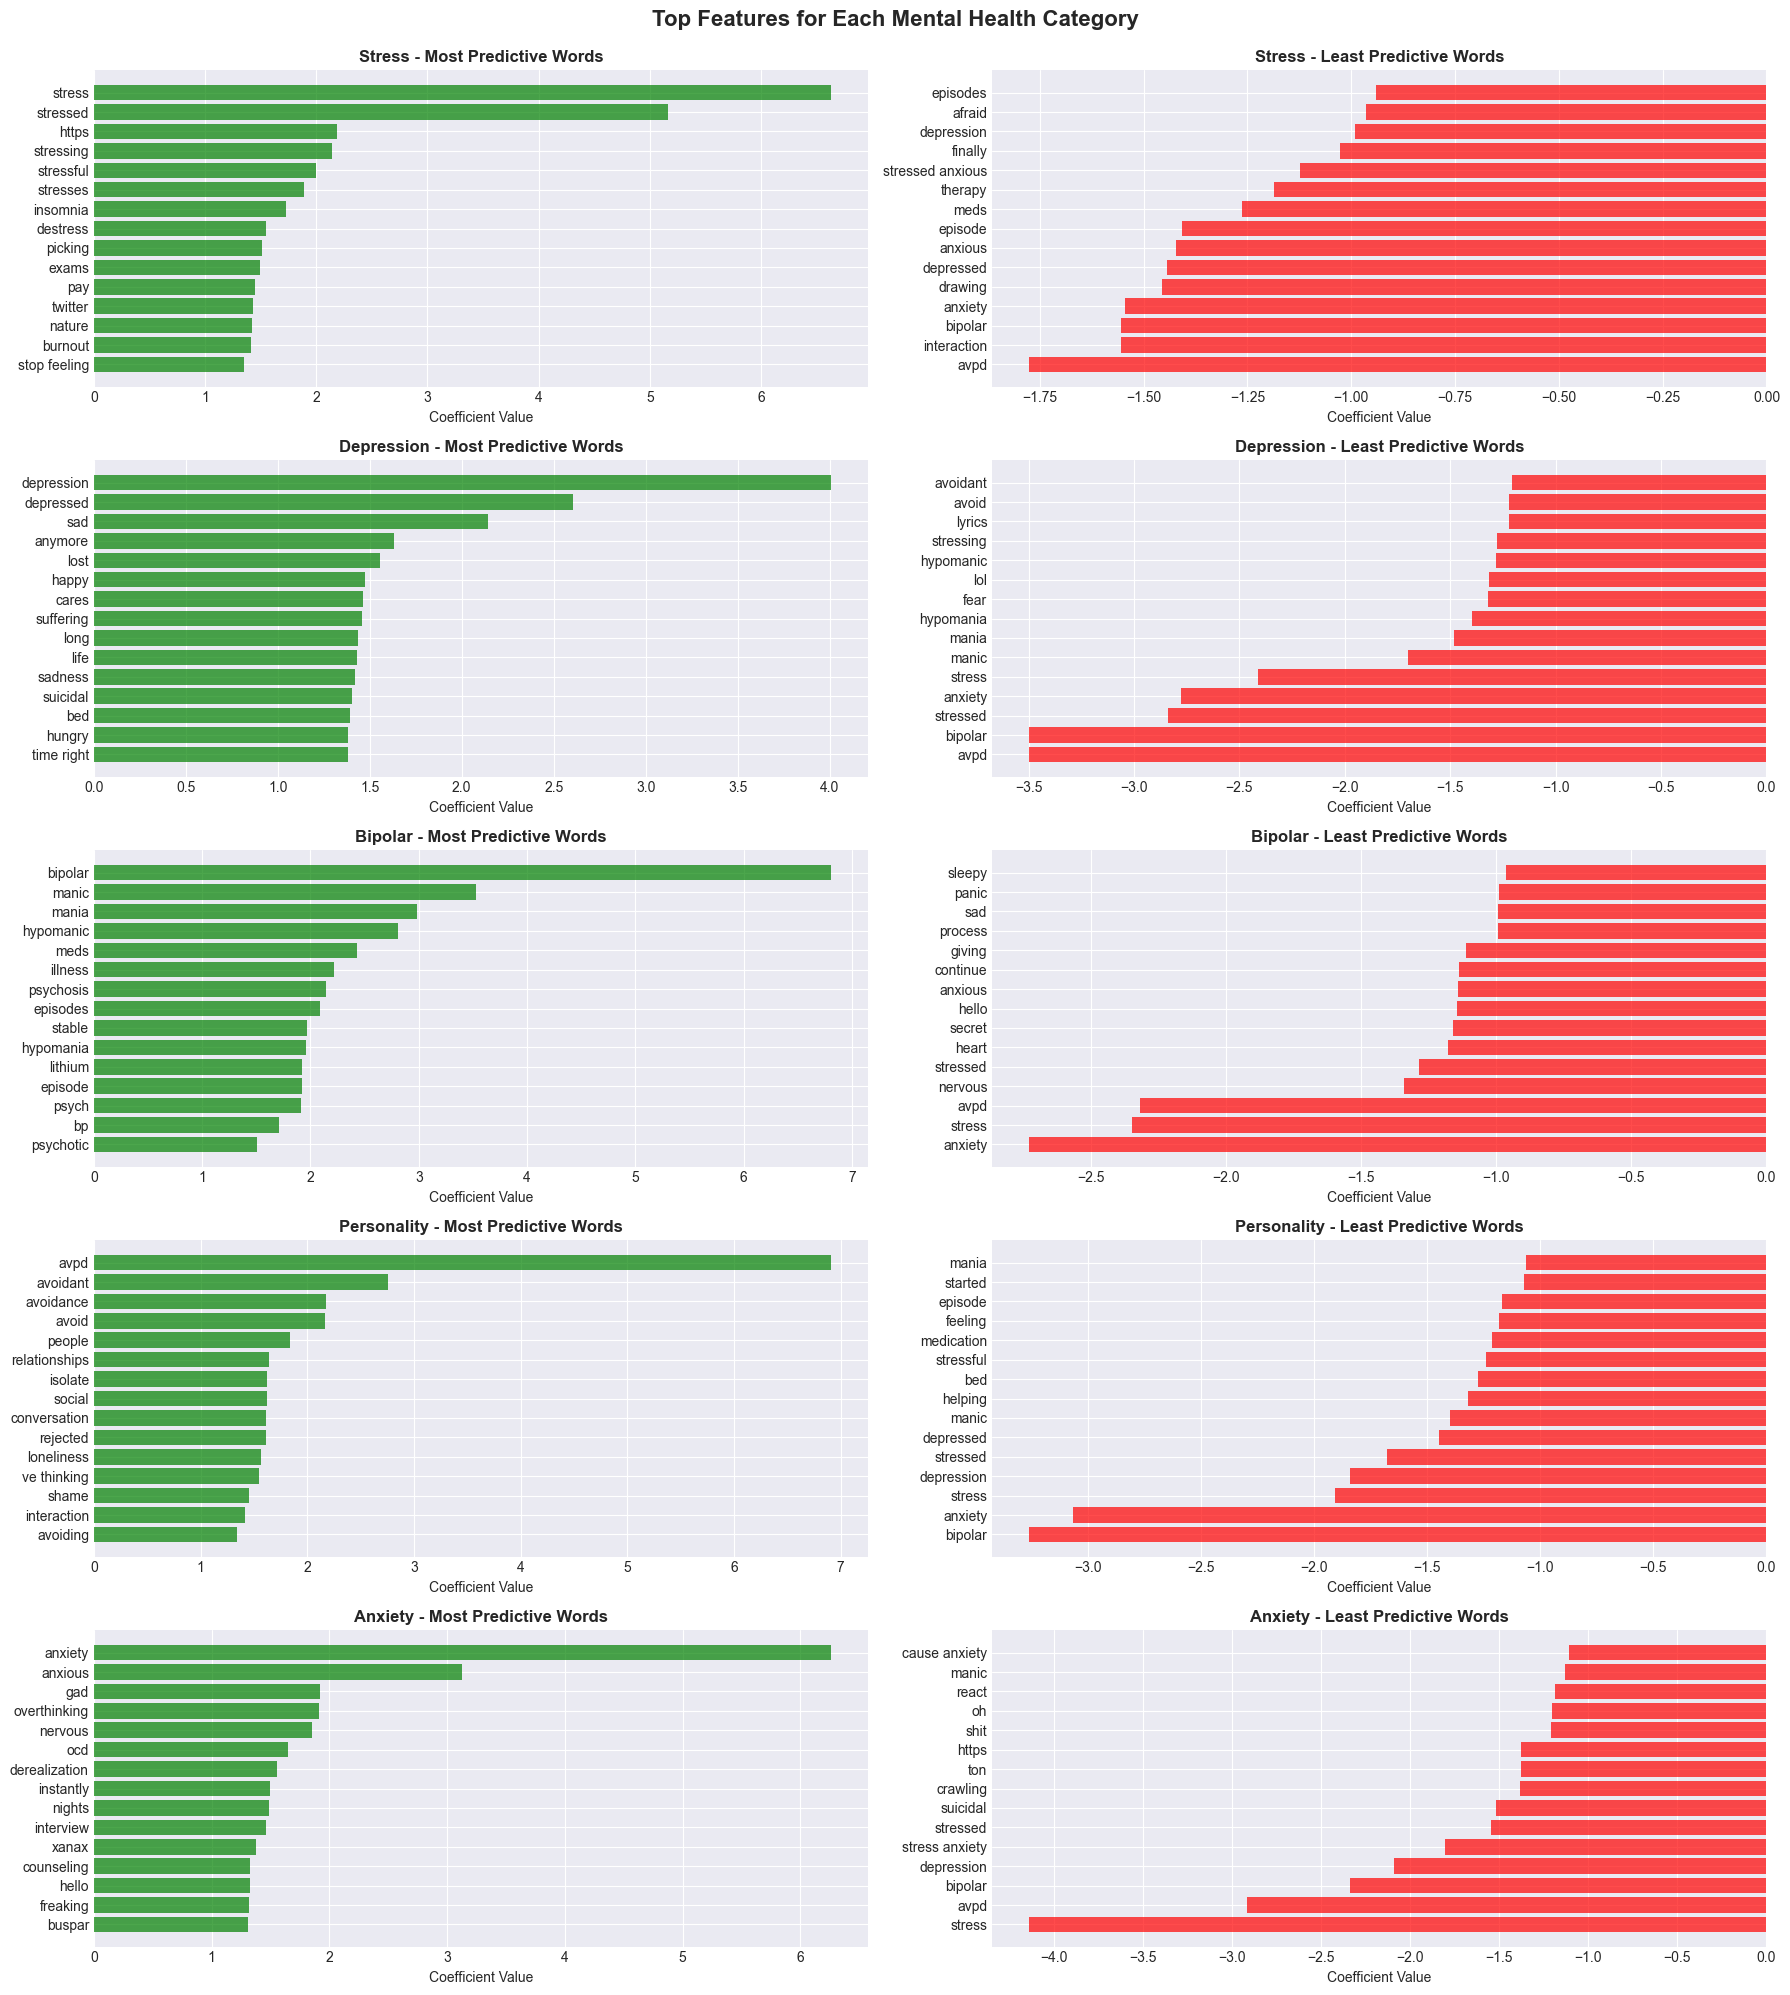


🔍 Analysis: These words have the strongest influence on predictions!


In [11]:
# Feature Importance Analysis
print("=== FEATURE IMPORTANCE ANALYSIS ===")

feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_

# Create a comprehensive feature importance analysis
n_top = 15

fig, axes = plt.subplots(5, 2, figsize=(18, 20))
fig.suptitle('Top Features for Each Mental Health Category', fontsize=16, fontweight='bold', y=0.995)

for i, class_name in enumerate(class_names):
    # Top positive features (most predictive)
    top_positive_idx = np.argsort(coefficients[i])[-n_top:]
    top_positive_words = [feature_names[idx] for idx in top_positive_idx]
    top_positive_scores = [coefficients[i][idx] for idx in top_positive_idx]
    
    # Top negative features (least predictive)
    top_negative_idx = np.argsort(coefficients[i])[:n_top]
    top_negative_words = [feature_names[idx] for idx in top_negative_idx]
    top_negative_scores = [coefficients[i][idx] for idx in top_negative_idx]
    
    # Plot positive features
    ax1 = axes[i, 0]
    ax1.barh(top_positive_words, top_positive_scores, color='green', alpha=0.7)
    ax1.set_title(f'{class_name} - Most Predictive Words', fontweight='bold')
    ax1.set_xlabel('Coefficient Value')
    
    # Plot negative features
    ax2 = axes[i, 1]
    ax2.barh(top_negative_words, top_negative_scores, color='red', alpha=0.7)
    ax2.set_title(f'{class_name} - Least Predictive Words', fontweight='bold')
    ax2.set_xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

print("\n🔍 Analysis: These words have the strongest influence on predictions!")
print("="*50)

=== WORD CLOUD VISUALIZATION ===


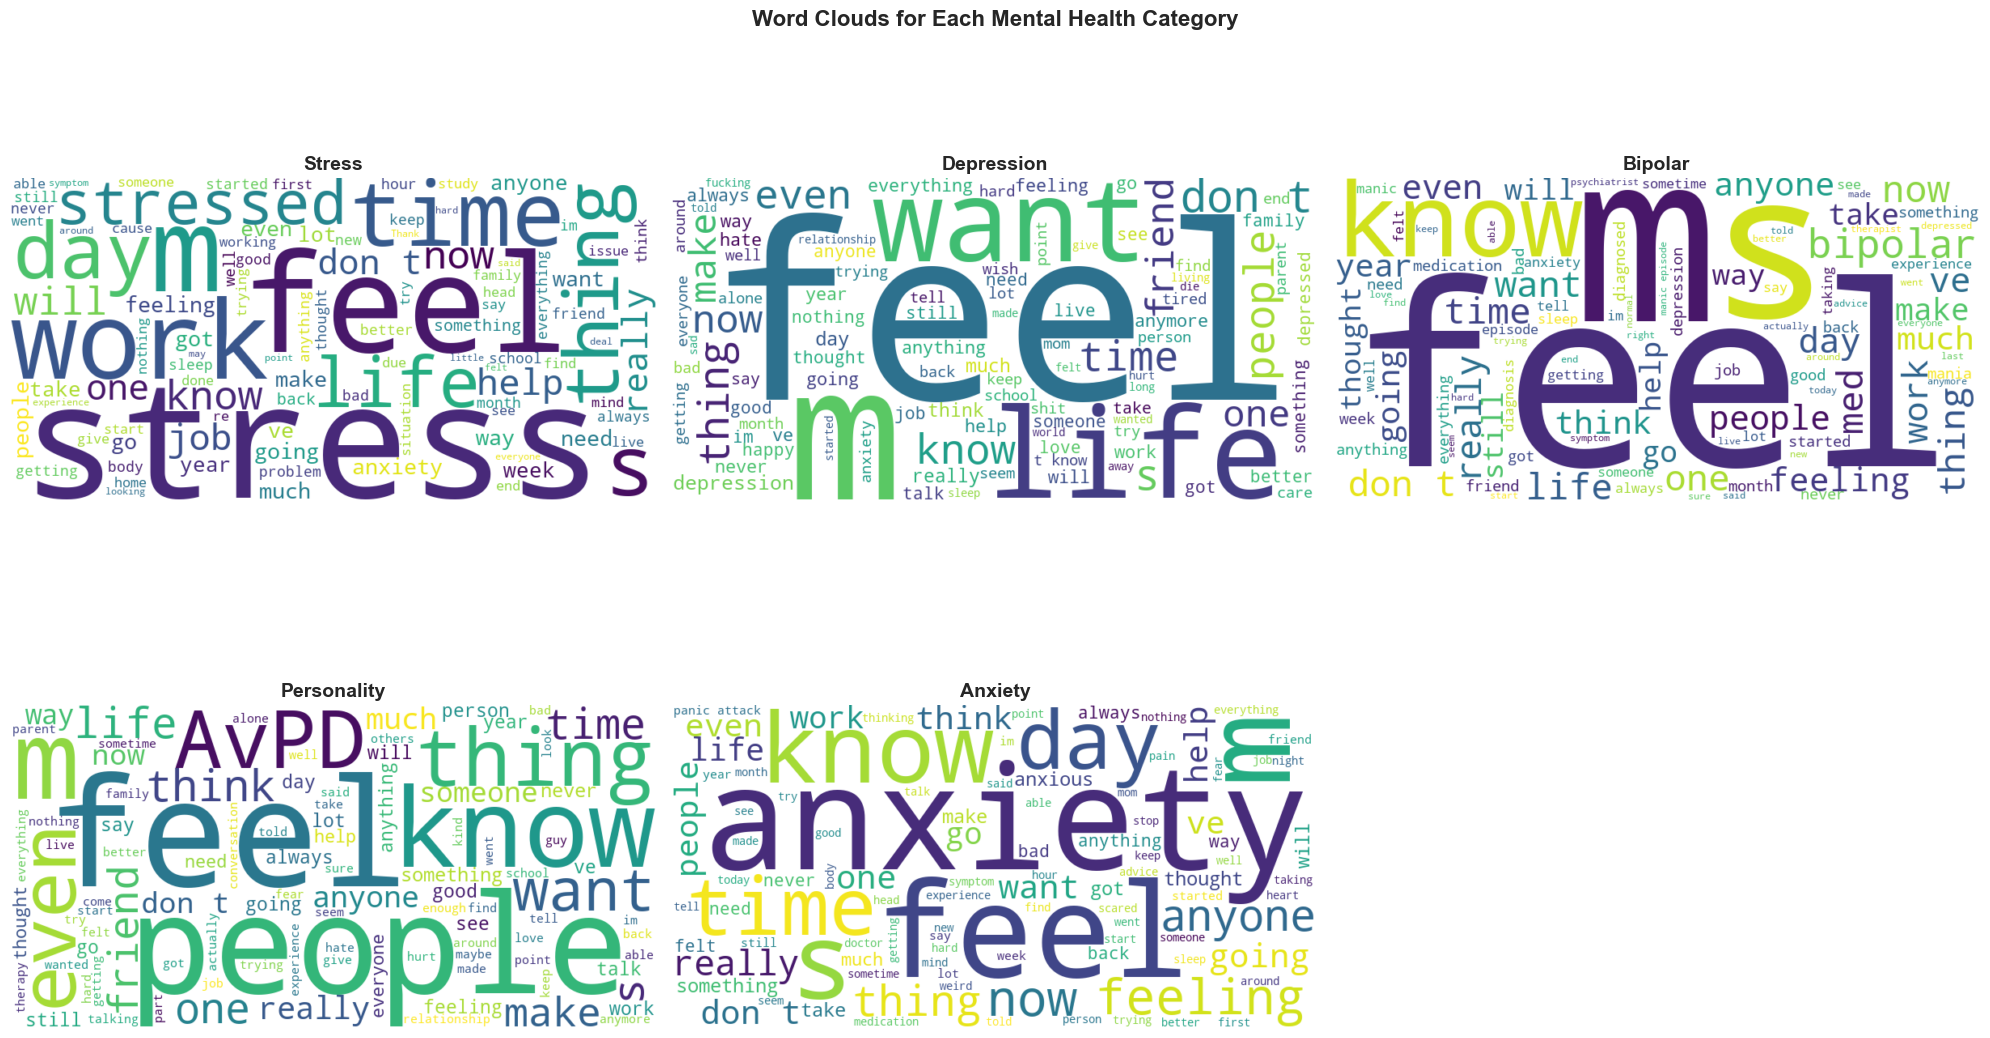


☁️ Word clouds show the most frequent words in each category!


In [12]:
# Word Cloud Visualization
print("=== WORD CLOUD VISUALIZATION ===")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Word Clouds for Each Mental Health Category', fontsize=16, fontweight='bold')

for i, class_name in enumerate(class_names):
    # Get texts for this class
    class_texts = df[df['target'] == i]['content'].values
    all_text = ' '.join(class_texts)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5
    ).generate(all_text)
    
    # Plot
    ax = axes[i // 3, i % 3]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{class_name}', fontsize=14, fontweight='bold')
    ax.axis('off')

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

print("\n☁️ Word clouds show the most frequent words in each category!")
print("="*50)

=== MISCLASSIFICATION ANALYSIS ===
Total misclassifications: 225
Misclassification rate: 18.88%



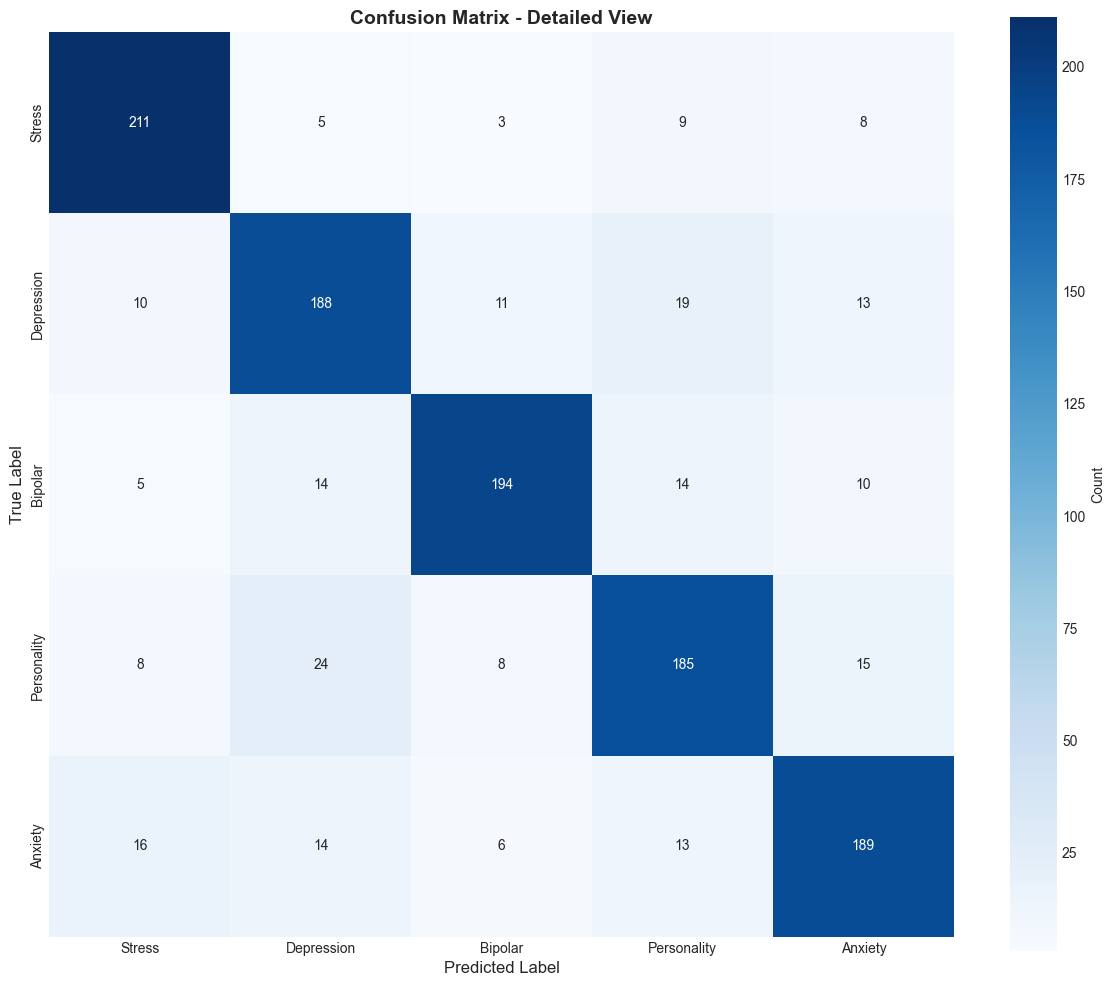


🔍 Most Common Misclassification Patterns:
  Personality → Depression: 24 cases
  Depression → Personality: 19 cases
  Anxiety → Stress: 16 cases
  Personality → Anxiety: 15 cases
  Bipolar → Depression: 14 cases
  Bipolar → Personality: 14 cases
  Anxiety → Depression: 14 cases
  Depression → Anxiety: 13 cases
  Anxiety → Personality: 13 cases
  Depression → Bipolar: 11 cases


In [13]:
# Detailed Misclassification Analysis
print("=== MISCLASSIFICATION ANALYSIS ===")

# Get misclassified examples
misclassified_mask = y_pred != y_test
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total misclassifications: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_test)*100:.2f}%\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            square=True, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Detailed View', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze common misclassification pairs
print("\n🔍 Most Common Misclassification Patterns:")
misclass_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            misclass_pairs.append((class_names[i], class_names[j], cm[i][j]))

misclass_pairs.sort(key=lambda x: x[2], reverse=True)
for true_label, pred_label, count in misclass_pairs[:10]:
    print(f"  {true_label} → {pred_label}: {count} cases")

print("="*50)

In [14]:
# Sample Misclassified Examples
print("=== SAMPLE MISCLASSIFIED EXAMPLES ===")

# Show 10 misclassified examples
n_samples = min(10, len(misclassified_indices))

for i in range(n_samples):
    idx = misclassified_indices[i]
    original_idx = X_test.index[idx]
    
    true_class = class_names[y_test.iloc[idx]]
    pred_class = class_names[y_pred[idx]]
    text = X_test.iloc[idx]
    
    # Get confidence scores
    decision_scores = model.decision_function(X_test_tfidf[idx])
    
    print(f"\n{'='*80}")
    print(f"Example {i+1}:")
    print(f"True Category: {true_class}")
    print(f"Predicted: {pred_class}")
    print(f"\nText (first 300 chars):")
    print(f"{text[:300]}...")
    print(f"\nDecision Scores: {dict(zip(class_names, decision_scores[0]))}")
    
print("\n" + "="*80)
print("\n💡 Insight: These examples show where the model struggles!")
print("="*50)

=== SAMPLE MISCLASSIFIED EXAMPLES ===

Example 1:
True Category: Bipolar
Predicted: Anxiety

Text (first 300 chars):
I’m so anxious. All the god damn time. I can’t go to my uni classes, I can’t get a job, I can’t write an email, I can barely leave the house. I don’t want to leave the house. I’m scared of everything.

I don’t even know what I’m scared of I just am. I’m just anxious. I was stable for like a year and...

Decision Scores: {'Stress': np.float64(-1.5280485490359932), 'Depression': np.float64(-0.7954438618424395), 'Bipolar': np.float64(-0.6338167294746716), 'Personality': np.float64(-0.9634232975494219), 'Anxiety': np.float64(-0.08147738006815652)}

Example 2:
True Category: Anxiety
Predicted: Personality

Text (first 300 chars):
Bringing reusable bags to the grocery store feels so off There is nothing worse than when you get to self checkout and there are literally no bags. They’ve started doing this at chains around me long ago and I still miss plastic bags!

Bringing reusa

=== PER-CLASS PERFORMANCE ANALYSIS ===

📊 Performance Metrics by Category:
   Category  Precision   Recall  F1-Score  Support
     Stress   0.844000 0.894068  0.868313    236.0
 Depression   0.767347 0.780083  0.773663    241.0
    Bipolar   0.873874 0.818565  0.845316    237.0
Personality   0.770833 0.770833  0.770833    240.0
    Anxiety   0.804255 0.794118  0.799154    238.0


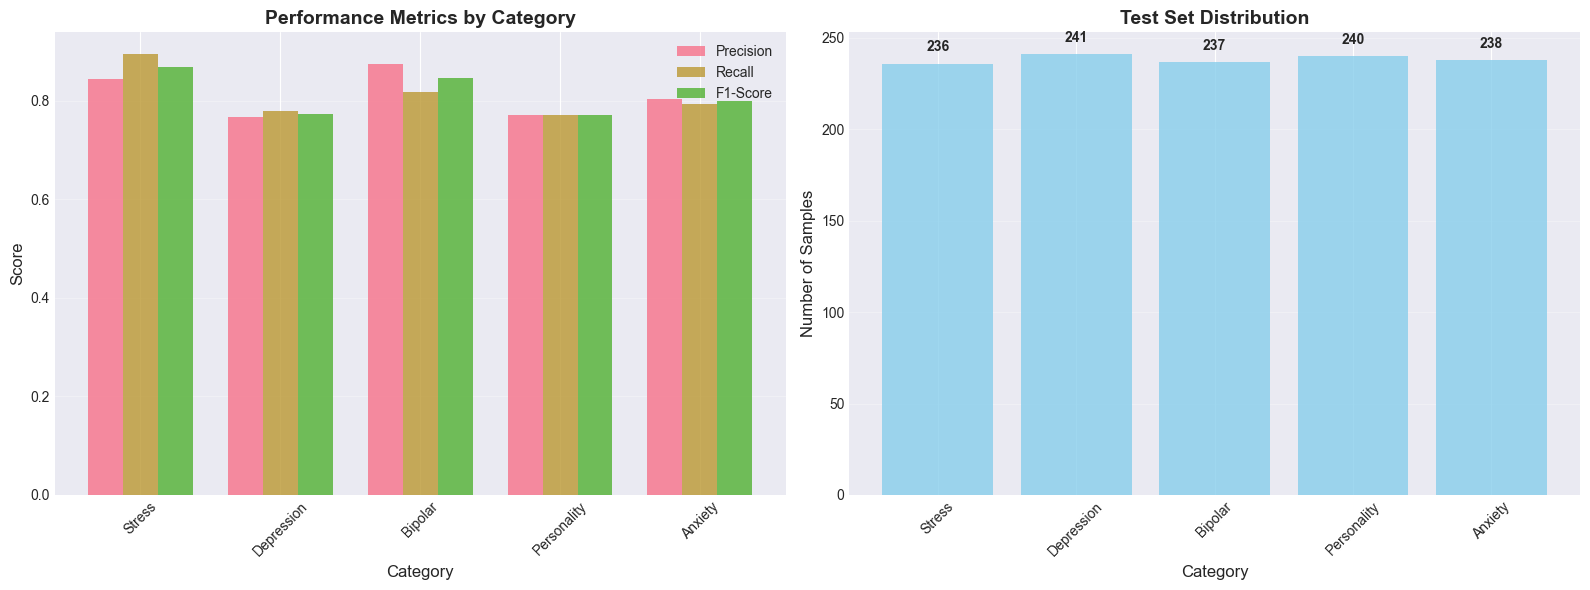


✅ Analysis complete!


In [15]:
# Per-Class Performance Analysis
print("=== PER-CLASS PERFORMANCE ANALYSIS ===")

# Get classification report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Create performance dataframe
metrics_df = pd.DataFrame({
    'Category': class_names,
    'Precision': [report[name]['precision'] for name in class_names],
    'Recall': [report[name]['recall'] for name in class_names],
    'F1-Score': [report[name]['f1-score'] for name in class_names],
    'Support': [report[name]['support'] for name in class_names]
})

print("\n📊 Performance Metrics by Category:")
print(metrics_df.to_string(index=False))

# Visualize metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Precision, Recall, F1-Score
x = np.arange(len(class_names))
width = 0.25

axes[0].bar(x - width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, metrics_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', alpha=0.8)

axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics by Category', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Support distribution
axes[1].bar(class_names, metrics_df['Support'], color='skyblue', alpha=0.8)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(metrics_df['Support']):
    axes[1].text(i, v + 5, str(int(v)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")
print("="*50)

In [16]:
# Key Insights Summary
print("=== KEY INSIGHTS SUMMARY ===")

# Best and worst performing categories
best_category = metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Category']
worst_category = metrics_df.loc[metrics_df['F1-Score'].idxmin(), 'Category']

print(f"\n🏆 Best Performing Category: {best_category}")
print(f"   F1-Score: {metrics_df.loc[metrics_df['Category'] == best_category, 'F1-Score'].values[0]:.4f}")

print(f"\n⚠️ Needs Improvement: {worst_category}")
print(f"   F1-Score: {metrics_df.loc[metrics_df['Category'] == worst_category, 'F1-Score'].values[0]:.4f}")

# Most confused pair
if misclass_pairs:
    most_confused = misclass_pairs[0]
    print(f"\n🔄 Most Confused Pair: {most_confused[0]} ↔ {most_confused[1]}")
    print(f"   Misclassifications: {most_confused[2]} cases")

print(f"\n📈 Overall Model Performance:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
print(f"   Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")

print("\n💡 Recommendations for Improvement:")
print(f"   1. Collect more data for '{worst_category}' category")
print(f"   2. Investigate why '{most_confused[0]}' and '{most_confused[1]}' are confused")
print(f"   3. Consider feature engineering for better separation")
print(f"   4. Try ensemble methods or deep learning models")

print("\n" + "="*50)
print("🎉 Model Interpretability Analysis Complete!")
print("="*50)

=== KEY INSIGHTS SUMMARY ===

🏆 Best Performing Category: Stress
   F1-Score: 0.8683

⚠️ Needs Improvement: Personality
   F1-Score: 0.7708

🔄 Most Confused Pair: Personality ↔ Depression
   Misclassifications: 24 cases

📈 Overall Model Performance:
   Accuracy: 0.8112
   Macro Avg F1-Score: 0.8115
   Weighted Avg F1-Score: 0.8112

💡 Recommendations for Improvement:
   1. Collect more data for 'Personality' category
   2. Investigate why 'Personality' and 'Depression' are confused
   3. Consider feature engineering for better separation
   4. Try ensemble methods or deep learning models

🎉 Model Interpretability Analysis Complete!
